## Modelling

$\bullet$ Week 0 Wednesday Modelling using scikit-learn, Gensim, or other packages and APIs to model the topics       discussed in the tweets and their sentiments. You may use word clouds, k-mean clustering, etc. as a simple         model for topic modelling.
    Unlike data wrangling, this is widely the interesting part in general data analysis. The step here are as         follows:

$\bullet$ determine the set of algorithms to try on the data (classification, regression, neural-net etc).

$\bullet$ model design - data splitting.

$\bullet$ model building

$\bullet$ evaluation (metrics)

$\bullet$ model review

## Imports


Importing all the required packages for this task


In [1]:
# pandas library and other Python modules
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from nltk import pos_tag # For Parts of Speech tagging
import string # Inbuilt string library
# WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image # for opening, manipulating, and saving many different image file f
from textblob import TextBlob 
import matplotlib.pyplot as plt
import random 
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import joblib
import pickle

Load Dataset

In [91]:
model_tweets = pd.read_csv('../data/clean_processed_tweet.csv')
model_tweets = model_tweets.fillna("")
model_tweets.head()

,Unnamed: 0,created_at,source,Original_Text,full_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,possibly_sensitive,hashtags,user_mentions,place
0,0,2022-08-07 22:31:20+00:00,['source'],RT @i_ameztoy: Extra random image (I):\n\nLets...,iameztoy extra random image lets focus specifi...,0,-1.250000e-01,0.190625,en,0,2,,City,i_ameztoy,
1,1,2022-08-07 22:31:16+00:00,['source'],RT @IndoPac_Info: #China's media explains the ...,indopacinfo chinas media explains military rea...,0,-1.000000e-01,0.100000,en,0,201,,"China, Taiwan",IndoPac_Info,
2,2,2022-08-07 22:31:07+00:00,['source'],"China even cut off communication, they don't a...",china even cut communication dont anwer phonec...,-1,0.000000e+00,0.000000,en,0,0,,XiJinping,ZelenskyyUa,Netherlands
3,3,2022-08-07 22:31:06+00:00,['source'],"Putin to #XiJinping : I told you my friend, Ta...",putin xijinping told friend taiwan vassal stat...,1,1.000000e-01,0.350000,en,0,0,,XiJinping,,Netherlands
4,4,2022-08-07 22:31:04+00:00,['source'],"RT @ChinaUncensored: I’m sorry, I thought Taiw...",chinauncensored im sorry thought taiwan indepe...,0,-6.938894e-18,0.556250,en,0,381,,,ChinaUncensored,"Ayent, Schweiz"


# Building a Sentiment Classifier using Scikit-Learn

<center><img src="https://raw.githubusercontent.com/lazuxd/simple-imdb-sentiment-analysis/master/smiley.jpg"/></center>
<center><i>Image by AbsolutVision @ <a href="https://pixabay.com/ro/photos/smiley-emoticon-furie-sup%C4%83rat-2979107/">pixabay.com</a></i></center>

> &nbsp;&nbsp;&nbsp;&nbsp;**Sentiment analysis**, an important area in Natural Language Processing, is the process of automatically detecting affective states of text. Sentiment analysis is widely applied to voice-of-customer materials such as product reviews in online shopping websites like Amazon, movie reviews or social media. It can be just a basic task of classifying the polarity of a text as being positive/negative or it can go beyond polarity, looking at emotional states such as "happy", "angry", etc.




Basic EDA

In [57]:
import seaborn as sns
%matplotlib inline
# plot params
plot_size = plt.rcParams["figure.figsize"] 
plot_size[0] = 15
plot_size[1] = 16
plt.rcParams["figure.figsize"] = plot_size 

<AxesSubplot:ylabel='place'>

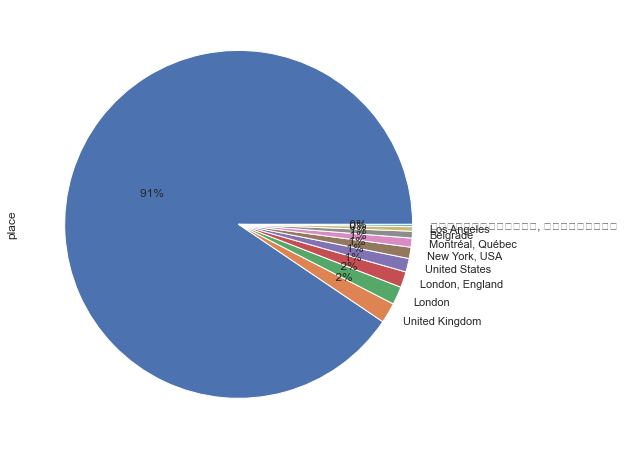

In [59]:
# number of tweets for each 
sns.set(rc={'figure.figsize':(10,8)})
model_tweets.place.value_counts().drop_duplicates().plot(kind='pie', autopct='%10.0f%%')

visualize the Distribution of sentiments

<AxesSubplot:ylabel='sentiment'>

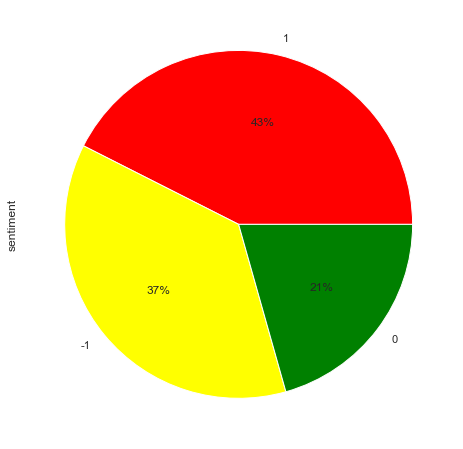

In [60]:
# Distribution of sentiments across all the tweets.
sns.set(rc={'figure.figsize':(10,8)})
model_tweets.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

<AxesSubplot:xlabel='lang'>

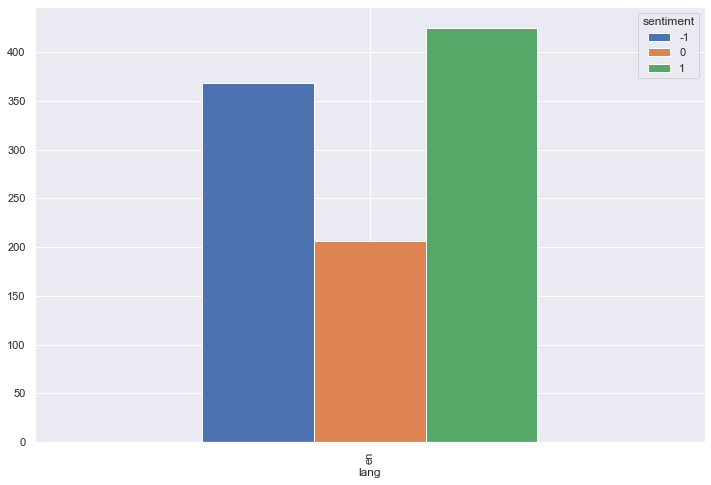

In [61]:
sns.set(rc={'figure.figsize':(12,8)})
sentiment = model_tweets.groupby(['lang', 'sentiment']).sentiment.count().unstack()
sentiment.plot(kind='bar')

## Data preprocessing

&nbsp;&nbsp;&nbsp;&nbsp;After the dataset has been downloaded and extracted from archive we have to transform it into a more suitable form for feeding it into a machine learning model for training. We will start by combining all review data into 2 pandas Data Frames representing the train and test datasets, and then saving them as csv file.  

&nbsp;&nbsp;&nbsp;&nbsp;The Data Frames will have the following form:  

|text       |label      |
|:---------:|:---------:|
|review1    |0          |
|review2    |1          |
|review3    |1          |
|.......    |...        |
|reviewN    |0          |  

&nbsp;&nbsp;&nbsp;&nbsp;where:  
- review1, review2, ... = the actual text of movie review  
- 0 = negative review  
- 1 = positive review

<b>But machine learnng algorithms work only with numerical values.</b> We can't just input the text itself into a machine learning model and have it learn from that. We have to, somehow, <b>represent the text by numbers or vectors of numbers</b>. One way of doing this is by using the **Bag-of-words** model<sup>(3)</sup>, in which a piece of text (often called a **document**) is represented by a <b>vector of the counts of words from a vocabulary in that document. This model doesn't take into account grammar rules or word ordering; all it considers is the frequency of words</b>. If we use the counts of each word independently we name this representation a **unigram**. In general, in a **n-gram** we take into account the counts of <b>each combination of n words from the vocabulary that appears in a given document</b>.  

&nbsp;&nbsp;&nbsp;&nbsp;For example, consider these two documents:  
<br>  
<div style="font-family: monospace;"><center><b>d1: "I am learning"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</b></center></div>  
<div style="font-family: monospace;"><center><b>d2: "Machine learning is cool"</b></center></div>  
<br>
The vocabulary of all words encountered in these two sentences is: 

<br/>  
<div style="font-family: monospace;"><center><b>v: [ I, am, learning, machine, is, cool ]</b></center></div>   
<br>
&nbsp;&nbsp;&nbsp;&nbsp;The unigram representations of d1 and d2:  
<br>  

|unigram(d1)|I       |am      |learning|machine |is      |cool    |
|:---------:|:------:|:------:|:------:|:------:|:------:|:------:|
|           |1       |1       |1       |0       |0       |0       |  

|unigram(d2)|I       |am      |learning|machine |is      |cool    |
|:---------:|:------:|:------:|:------:|:------:|:------:|:------:|
|           |0       |0       |1       |1       |1       |1       |
  
&nbsp;&nbsp;&nbsp;&nbsp;And, the bigrams of d1 and d2 are:
  
|bigram(d1) |I I     |I am    |I learning|...|machine am|machine learning|...|cool is|cool cool|
|:---------:|:------:|:------:|:--------:|:-:|:--------:|:--------------:|:-:|:-----:|:-------:|
|           |0       |1       |0         |...|0         |0               |...|0      |0        |  

|bigram(d2) |I I     |I am    |I learning|...|machine am|machine learning|...|cool is|cool cool|
|:---------:|:------:|:------:|:--------:|:-:|:--------:|:--------------:|:-:|:-----:|:-------:|
|           |0       |0       |0         |...|0         |1               |...|0      |0        |

&nbsp;&nbsp;&nbsp;&nbsp;Often, we can achieve slightly better results if instead of counts of words we use something called **term frequency times inverse document frequency** (or **tf-idf**). Maybe it sounds complicated, but it is not. Bear with me, I will explain this. The intuition behind this is the following. So, what's the problem of using just the frequency of terms inside a document? <b>Although some terms may have a high frequency inside documents they may not be so relevant for describing a given document in which they appear. That's because those terms may also have a high frequency across the collection of all documents</b>. For example, a collection of movie reviews may have terms specific to movies/cinematography that are present in almost all documents (they have a high **document frequency**). So, when we encounter those terms in a document this doesn't tell much about whether it is a positive or negative review. We need a way of relating **term frequency** (how frequent a term is inside a document) to **document frequency** (how frequent a term is across the whole collection of documents). That is:  
  
$$\begin{align}\frac{\text{term frequency}}{\text{document frequency}} &= \text{term frequency} \cdot \frac{1}{\text{document frequency}} \\ &= \text{term frequency} \cdot \text{inverse document frequency} \\ &= \text{tf} \cdot \text{idf}\end{align}$$  
  
&nbsp;&nbsp;&nbsp;&nbsp;Now, there are more ways used to describe both term frequency and inverse document frequency. But the most common way is by putting them on a logarithmic scale:  
  
$$tf(t, d) = log(1+f_{t,d})$$  
$$idf(t) = log(\frac{1+N}{1+n_t})$$  
  
&nbsp;&nbsp;&nbsp;&nbsp;where:  
$$\begin{align}f_{t,d} &= \text{count of term } \textbf{t} \text{ in document } \textbf{d} \\  
N &= \text{total number of documents} \\  
n_t &= \text{number of documents that contain term } \textbf{t}\end{align}$$  
  
<b>We added 1 in the first logarithm to avoid getting $-\infty$ when $f_{t,d}$ is 0. In the second logarithm we added one fake document to avoid division by zero.</b>

Before we transform our data into vectors of counts or tf-idf values we should remove English **stopwords**<sup>(6)(7)</sup>. <b>Stopwords are words that are very common in a language</b> and are usually removed in the preprocessing stage of natural text-related tasks like sentiment analysis or search.

<b>Note that we should construct our vocabulary only based on the training set. When we will process the test data in order to make predictions we should use only the vocabulary constructed in the training phase, the rest of the words will be ignored.</b>

&nbsp;&nbsp;&nbsp;&nbsp;Now, let's create the data frames and save them as csv files:

### Text vectorization

Fortunately, for the text vectorization part all the hard work is already done in the Scikit-Learn classes `CountVectorizer`<sup>(8)</sup> and `TfidfTransformer`<sup>(5)</sup>. We will use these classes to transform our csv files into unigram and bigram matrices (using both counts and tf-idf values). (<b>It turns out that if we only use a n-gram for a large n we don't get a good accuracy, we usually use all n-grams up to some n. So, when we say here bigrams we actually refer to uni+bigrams and when we say unigrams it's just unigrams.</b>) Each row in those matrices will represent a document (review) in our dataset, and each column will represent values associated with each word in the vocabulary (in the case of unigrams) or values associated with each combination of maximum 2 words in the vocabulary (bigrams).  

&nbsp;&nbsp;&nbsp;&nbsp;`CountVectorizer` has a parameter `ngram_range` which expects a tuple of size 2 that controls what n-grams to include. After we constructed a `CountVectorizer` object we should call `.fit()` method with the actual text as a parameter, in order for it to learn the required statistics of our collection of documents. Then, by calling `.transform()` method with our collection of documents it returns the matrix for the n-gram range specified. As the class name suggests, this matrix will contain just the counts. To obtain the tf-idf values, the class `TfidfTransformer` should be used. It has the `.fit()` and `.transform()` methods that are used in a similar way with those of `CountVectorizer`, but they take as input the counts matrix obtained in the previous step and `.transform()` will return a matrix with tf-idf values. We should use `.fit()` only on training data and then store these objects. When we want to evaluate the test score or whenever we want to make a prediction we should use these objects to transform the data before feeding it into our classifier.  

&nbsp;&nbsp;&nbsp;&nbsp;Note that the matrices generated for our train or test data will be huge, and if we store them as normal numpy arrays they will not even fit into RAM. But most of the entries in these matrices will be zero. So, these Scikit-Learn classes are using Scipy sparse matrices<sup>(9)</sup> (`csr_matrix`<sup>(10)</sup> to be more exactly), which store just the non-zero entries and save a LOT of space.  

&nbsp;&nbsp;&nbsp;&nbsp;We will use a linear classifier with stochastic gradient descent, `sklearn.linear_model.SGDClassifier`<sup>(11)</sup>, as our model. First we will generate and save our data in 4 forms: unigram and bigram matrix (with both counts and tf-idf values for each). Then we will train and evaluate our model for each these 4 data representations using `SGDClassifier` with the default parameters. After that, we choose the data representation which led to the best score and we will tune the hyper-parameters of our model with this data form using cross-validation in order to obtain the best results.

<b>Refs:</b> 
* Convert a collection of text documents to a matrix of token counts: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* Convert a collection of raw documents to a matrix of TF-IDF features: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


#### Unigram Counts

In [62]:
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(model_tweets['full_text'].values)

CountVectorizer()

In [63]:
unigram_vectorizer.vocabulary_

{'iameztoy': 1230,
 'extra': 894,
 'random': 2006,
 'image': 1248,
 'lets': 1454,
 'focus': 973,
 'specific': 2349,
 'zone': 2893,
 'western': 2803,
 'coast': 494,
 'gt': 1115,
 'longjing': 1493,
 'district': 736,
 'taichung': 2456,
 'city': 472,
 'ta': 2452,
 'indopacinfo': 1271,
 'chinas': 443,
 'media': 1568,
 'explains': 887,
 'military': 1589,
 'reasons': 2033,
 'area': 136,
 'drills': 760,
 'taiwan': 2462,
 'strait': 2401,
 'read': 2021,
 'labels': 1420,
 'pi': 1852,
 'china': 431,
 'even': 860,
 'cut': 625,
 'communication': 519,
 'dont': 746,
 'anwer': 120,
 'phonecalls': 1849,
 'us': 2683,
 'clown': 485,
 'zelenskyyua': 2886,
 'enters': 837,
 'stage': 2367,
 'ask': 160,
 'xijinping': 2864,
 'change': 414,
 'putins': 1993,
 'mind': 1598,
 'putin': 1992,
 'told': 2570,
 'friend': 1022,
 'vassal': 2708,
 'state': 2378,
 'including': 1261,
 'nukes': 1730,
 'like': 1464,
 'ukrainian': 2651,
 'model': 1619,
 'warned': 2768,
 'took': 2574,
 'pelosi': 1824,
 'open': 1765,
 'eyes': 897

In [64]:
df = pd.DataFrame(unigram_vectorizer.vocabulary_.items(), columns=['Vocabulary', 'Frequency'])

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2897 entries, 0 to 2896
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Vocabulary  2897 non-null   object
 1   Frequency   2897 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.4+ KB


In [66]:
df.sort_values(by="Frequency", axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')

In [67]:
df.head(n=20)

,Vocabulary,Frequency
1959,zunzuneo,2896
2292,zsuzsettte,2895
2068,zoom,2894
7,zone,2893
1307,zlj,2892
2724,zjz,2891
1023,zhoulichn,2890
1198,zheng,2889
2528,zhangheqing,2888
2322,zerosum,2887


In [68]:
df.tail(n=20)

,Vocabulary,Frequency
1212,activity,19
999,activities,18
2576,actions,17
1760,action,16
714,acti,15
325,act,14
406,across,13
934,accuses,12
375,accounting,11
147,accepted,10


Unigram

In [72]:
X_train_unigram = unigram_vectorizer.transform(model_tweets['full_text'].values)

In [73]:
unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)

TfidfTransformer()

<b> fit_transform </b>

In [74]:
X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)

Bigram

In [85]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(model_tweets['full_text'].values)

CountVectorizer(ngram_range=(1, 2))

In [86]:
X_train_bigram = bigram_vectorizer.transform(model_tweets['full_text'].values)

In [87]:
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

TfidfTransformer()

In [79]:
X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

In [88]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)

    global_vars = globals()
    if(valid_score > global_vars['best_score']):
        global_vars['best_model'] = clf
        global_vars['best_model_name'] = title
        global_vars['best_score'] = valid_score

    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [89]:
y_train = model_tweets['sentiment'].values
y_train

array([ 0,  0, -1,  1,  0,  1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  0,
        0, -1, -1,  0, -1,  1, -1,  0,  1,  0, -1, -1,  1,  1,  0,  1, -1,
        1,  1, -1,  0,  1,  0,  1,  0, -1, -1,  1,  1,  0, -1,  1, -1, -1,
        0,  1,  0, -1,  1,  1,  1, -1,  1,  1,  1,  0, -1,  0, -1,  0, -1,
       -1,  0,  1,  0, -1, -1, -1,  1,  0,  1, -1,  1,  1,  1,  1,  0, -1,
        1,  1, -1,  1, -1,  1,  0, -1, -1, -1,  1, -1,  0,  1, -1, -1,  0,
        1,  1,  0, -1, -1,  0,  1,  1,  1,  0,  1, -1, -1, -1,  1, -1,  1,
       -1,  1, -1, -1,  1, -1,  0,  0, -1,  1, -1,  1, -1, -1,  0,  1,  0,
        1,  1,  1,  1, -1, -1,  1, -1,  1,  0,  1,  0,  0,  0,  0,  1,  1,
        1,  1,  0,  1, -1, -1, -1,  1,  1,  0,  1,  0,  1,  1,  1, -1,  1,
       -1,  1,  0,  1,  1, -1, -1,  1, -1,  0,  1,  1,  1,  1, -1, -1,  0,
       -1,  1,  1,  1,  1, -1,  0, -1,  0,  1,  1,  1, -1, -1,  0, -1,  1,
        0, -1,  1, -1,  1,  1, -1,  1, -1, -1,  0, -1,  0, -1,  0,  1,  1,
        0,  1,  1,  1, -1

In [ ]:
model of n-gram

In [93]:
best_model = ""
best_model_name = ""
best_score = 0

train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

Unigram Counts
Train score: 1.0 ; Validation score: 0.83

Unigram Tf-Idf
Train score: 1.0 ; Validation score: 0.87

Bigram Counts
Train score: 1.0 ; Validation score: 0.86

Bigram Tf-Idf
Train score: 1.0 ; Validation score: 0.82



In [95]:
print(f'The best Model is {best_model_name} with a Validation score of: {round(best_score, 2)}')

The best Model is Unigram Tf-Idf with a Validation score of: 0.87


In [96]:
def run_test_using_model(best_model: SGDClassifier, model_type: str):
    unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
    unigram_vectorizer.fit(tweet_test['full_text'].values)
    X_test_unigram = unigram_vectorizer.transform(tweet_test['full_text'].values)

    bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
    bigram_vectorizer.fit(tweet_test['full_text'].values)
    X_test_bigram = bigram_vectorizer.transform(tweet_test['full_text'].values)

    y_test = tweet_test['sentiment'].values

    if(model_type == "Unigram Counts"):
        X_test = X_test_unigram

    elif(model_type == "Unigram Tf-Idf"):
        unigram_tf_idf_transformer = TfidfTransformer()
        unigram_tf_idf_transformer.fit(X_test_unigram)
        X_test_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_test_unigram)

        X_test = X_test_unigram_tf_idf

    elif(model_type == "Bigram Counts"):
        X_test = X_test_bigram

    else:
        bigram_tf_idf_transformer = TfidfTransformer()
        bigram_tf_idf_transformer.fit(X_test_bigram)

        X_test_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_test_bigram)
        X_test = X_test_bigram_tf_idf

   
    return best_model.score(X_test,y_test)

In [98]:
# saving generated LDA
sgd = joblib.dump(best_model, '../data/newsentimentSGDmodel.jl')

### Model

&nbsp;&nbsp;&nbsp;&nbsp;Now, for each data form we split it into train & validation sets, train a `SGDClassifier` and output the score.

In [97]:
#!pip3 install spacy
#!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 684 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=673143ccc792fe501319bb8669d1249b9f2d6828df65660d63c47f7bda17bfcb
  Stored in directory: /home/success/.cache/pip/wheels/57/a4/86/d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=8fe1bc60b0ca92b7a98048b3824d5b9afa23d3710ceb12a8451a12e5be9c8dd7
  Stored in directory: /home/success/.cache/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built pyLDAvis sklearn


In [111]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [113]:
topic_model_data = model_tweets.copy(deep=True)
topic_model_data

,Unnamed: 0,created_at,source,Original_Text,full_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,possibly_sensitive,hashtags,user_mentions,place
0,0,2022-08-07 22:31:20+00:00,['source'],RT @i_ameztoy: Extra random image (I):\n\nLets...,iameztoy extra random image lets focus specifi...,0,-1.250000e-01,0.190625,en,0,2,,City,i_ameztoy,
1,1,2022-08-07 22:31:16+00:00,['source'],RT @IndoPac_Info: #China's media explains the ...,indopacinfo chinas media explains military rea...,0,-1.000000e-01,0.100000,en,0,201,,"China, Taiwan",IndoPac_Info,
2,2,2022-08-07 22:31:07+00:00,['source'],"China even cut off communication, they don't a...",china even cut communication dont anwer phonec...,-1,0.000000e+00,0.000000,en,0,0,,XiJinping,ZelenskyyUa,Netherlands
3,3,2022-08-07 22:31:06+00:00,['source'],"Putin to #XiJinping : I told you my friend, Ta...",putin xijinping told friend taiwan vassal stat...,1,1.000000e-01,0.350000,en,0,0,,XiJinping,,Netherlands
4,4,2022-08-07 22:31:04+00:00,['source'],"RT @ChinaUncensored: I’m sorry, I thought Taiw...",chinauncensored im sorry thought taiwan indepe...,0,-6.938894e-18,0.556250,en,0,381,,,ChinaUncensored,"Ayent, Schweiz"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,2022-08-07 20:34:08+00:00,['source'],RT @RobertQ84643496: POLYMATECH INVESTS US$ 1 ...,robertq polymatech invests us billion semicond...,-1,0.000000e+00,0.000000,en,0,2,False,semiconductor,RobertQ84643496,Virginia
995,995,2022-08-07 20:34:05+00:00,['source'],"RT @SpokespersonCHN: ""#Taiwan is part of China...",spokespersonchn taiwan part china thats absolu...,1,1.333333e-01,0.433333,en,0,669,,Taiwan,SpokespersonCHN,
996,996,2022-08-07 20:34:02+00:00,['source'],"RT @IndoPac_Info: From Chinese media:\n\n""#PLA...",indopacinfo chinese media pla eastern theater ...,0,-5.000000e-02,0.050000,en,0,60,,"PLA, Taiwan",IndoPac_Info,"奈良県 奈良市 Nara, JAPAN"
997,997,2022-08-07 20:33:52+00:00,['source'],RT @IndoPac_Info: 1) A Lithuanian delegation h...,indopacinfo lithuanian delegation headed minis...,-1,0.000000e+00,0.000000,en,0,66,,Taiwan,IndoPac_Info,"奈良県 奈良市 Nara, JAPAN"


In [114]:
def get_hastags_words_list():
    hashtagList = []
    for hashtags in topic_model_data.hashtags:
        if(hashtags != ""):
            hashtagList += hashtags.split(',')

    return hashtagList

hashtag = get_hastags_words_list()

data = [word for sentence in topic_model_data.full_text for word in sentence.split(' ')]

In [115]:
hashtag[:5]

['City', 'China', ' Taiwan', 'XiJinping', 'XiJinping']

In [116]:
data_words = data + hashtag
data_words = [word for word in data_words if word != '']
data_words[:5]

['iameztoy', 'extra', 'random', 'image', 'lets']

In [117]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['i', 'a', 'm', 'e', 'z', 't', 'o', 'y']


In [118]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [122]:
#!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 95 kB/s eta 0:00:010
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [123]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [124]:
data_lemmatized = [word for word in data_lemmatized if word != []]
data_lemmatized[:5]

[['extra'], ['random'], ['image'], ['let'], ['focus']]

In [125]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus)

[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)], [(5, 1)], [(6, 1)], [(7, 1)], [(8, 1)], [(9, 1)], [(10, 1)], [(11, 1)], [(12, 1)], [(13, 1)], [(14, 1)], [(15, 1)], [(16, 1)], [(17, 1)], [(18, 1)], [(19, 1)], [(20, 1)], [(21, 1)], [(22, 1)], [(23, 1)], [(24, 1)], [(25, 1)], [(26, 1)], [(27, 1)], [(28, 1)], [(29, 1)], [(30, 1)], [(31, 1)], [(32, 1)], [(33, 1)], [(34, 1)], [(35, 1)], [(36, 1)], [(37, 1)], [(38, 1)], [(35, 1)], [(39, 1)], [(40, 1)], [(41, 1)], [(42, 1)], [(43, 1)], [(44, 1)], [(45, 1)], [(46, 1)], [(47, 1)], [(48, 1)], [(49, 1)], [(50, 1)], [(14, 1)], [(51, 1)], [(52, 1)], [(53, 1)], [(54, 1)], [(55, 1)], [(56, 1)], [(57, 1)], [(58, 1)], [(59, 1)], [(17, 1)], [(60, 1)], [(61, 1)], [(3, 1)], [(62, 1)], [(63, 1)], [(64, 1)], [(65, 1)], [(57, 1)], [(66, 1)], [(67, 1)], [(68, 1)], [(69, 1)], [(70, 1)], [(71, 1)], [(72, 1)], [(73, 1)], [(74, 1)], [(75, 1)], [(76, 1)], [(77, 1)], [(78, 1)], [(14, 1)], [(79, 1)], [(80, 1)], [(81, 1)], [(14, 1)], [(82, 1)], [(83, 1)], [(84, 1)]

## Compute Perplexity and Coherence Score

In [132]:
# View of word
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('extra', 1)],
 [('random', 1)],
 [('image', 1)],
 [('let', 1)],
 [('focus', 1)],
 [('specific', 1)],
 [('zone', 1)],
 [('western', 1)],
 [('coast', 1)],
 [('gt', 1)]]

In [127]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [133]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"aerial" + 0.001*"road" + 0.001*"subscribe" + 0.001*"mainstream" + '
  '0.001*"hide" + 0.001*"eicoofficial" + 0.001*"special" + 0.001*"newly" + '
  '0.001*"kachojawadali" + 0.001*"pic"'),
 (1,
  '0.193*"water" + 0.073*"yi" + 0.025*"include" + 0.000*"subscribe" + '
  '0.000*"mainstream" + 0.000*"hide" + 0.000*"eicoofficial" + 0.000*"aerial" + '
  '0.000*"newly" + 0.000*"pic"'),
 (2,
  '0.635*"chinese" + 0.050*"strait" + 0.040*"medium" + 0.017*"ambassador" + '
  '0.013*"scampfm" + 0.000*"rogerwater" + 0.000*"taiwanchina" + '
  '0.000*"ukraine" + 0.000*"hawaii" + 0.000*"nancypelosi"'),
 (3,
  '0.242*"house" + 0.078*"take" + 0.042*"extremely" + 0.000*"newly" + '
  '0.000*"mainstream" + 0.000*"hide" + 0.000*"eicoofficial" + 0.000*"aerial" + '
  '0.000*"section" + 0.000*"kachojawadali"'),
 (4,
  '0.162*"pelosis" + 0.049*"let" + 0.048*"read" + 0.000*"newly" + 0.000*"pic" '
  '+ 0.000*"hide" + 0.000*"eicoofficial" + 0.000*"aerial" + 0.000*"subscribe" '
  '+ 0.000*"road"'),
 (5,
 

In [134]:
# Compute Perplexity
perplexity_score = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity_score)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -26.84863418024337

Coherence Score:  0.7262780927784632


In [135]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/success/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.497651 -0.080037       1        1  17.752457
19    -0.037627 -0.019632       2        1   9.981208
2     -0.089033  0.354271       3        1   9.346570
16     0.018579 -0.025542       4        1   7.830300
10     0.035683 -0.019886       5        1   5.223331
3      0.035014 -0.020437       6        1   5.141129
11     0.036491 -0.019319       7        1   4.590099
14     0.037163 -0.018659       8        1   4.416535
8      0.037782 -0.018181       9        1   4.348557
1      0.038191 -0.017853      10        1   4.278161
15     0.032181 -0.021815      11        1   4.186730
4      0.039029 -0.016728      12        1   4.060035
12     0.039935 -0.014452      13        1   3.150469
13     0.040125 -0.012683      14        1   3.067773
7      0.039973 -0.011449      15        1   2.609216
9      0.039549 -0.009457      16        1   2.186002
6      0.038716 -0.007167      17        1   2.033716
5      0.038633 -0.006991      18        1   1.948477
18     0.038633 -0.006991      19        1   1.938152
0      0.038633 -0.006991      20        1   1.911083, topic_info=             Term         Freq        Total Category  logprob  loglift
49         pelosi  1571.000000  1571.000000  Default  30.0000  30.0000
85        chinese   611.000000   611.000000  Default  29.0000  29.0000
35        xijinpe   395.000000   395.000000  Default  28.0000  28.0000
75           part   248.000000   248.000000  Default  27.0000  27.0000
17       military   169.000000   169.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
22           read     0.098562    22.418639  Topic20  -7.5954  -1.4695
23          label     0.098562     3.803253  Topic20  -7.5954   0.3046
25           even     0.098562     6.675772  Topic20  -7.5954  -0.2581
26            cut     0.098562     2.704997  Topic20  -7.5954   0.6453
27  communication     0.098562     2.705004  Topic20  -7.5954   0.6453

[1095 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
86        3  0.857733   ambassador
19       11  0.877136         area
34        1  0.284082          ask
36        4  0.950515       change
14        8  0.983229        china
85        3  0.995668      chinese
66        2  0.872223      connive
57        1  0.971727      country
20        4  0.983531        drill
81        1  0.807045    elaborate
25       13  0.599182         even
16        7  0.902659      explain
67        6  0.893454    extremely
88        6  0.981982        house
43       10  0.824256      include
56        4  0.973382  independent
13       11  0.982049  indopacinfo
65        5  0.899980         kind
76       13  0.833512         know
23       17  0.262933        label
3        12  0.908496          let
15        3  0.928017       medium
17        5  0.985108     military
90        7  0.982996        nancy
84       14  0.873049        never
68        9  0.887503    offensive
75        2  0.988320         part
49        1  0.998240       pelosi
91       12  0.970277      pelosis
82       14  0.861520     position
83        2  0.914362     question
22       12  0.892115         read
18       16  0.838116       reason
69        2  0.872223       remark
74        9  0.974659          say
79        3  0.859444      scampfm
89        4  0.980588      speaker
42       13  0.940573        state
21        3  0.943119       strait
48        6  0.937760         take
39       11  0.719037         tell
55       15  0.935146        think
47       14  0.883647         warn
72       10  0.975084        water
35        2  0.992678      xijinpe
80       10  0.928299           yi, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 3, 17, 11, 4, 12, 15, 9, 2, 16, 5, 13, 14, 8, 10, 7, 6, 19, 1])

In [131]:
joblib.dump(lda_model, '../data/newtopicLDAmodel.jl')


['../data/newtopicLDAmodel.jl']

# Next

# Deployment
* Flask
* Streamlit

# References

<sup>(1)</sup> &nbsp;[Sentiment Analysis - Wikipedia](https://en.wikipedia.org/wiki/Sentiment_analysis)  
<sup>(2)</sup> &nbsp;[Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)  
<sup>(3)</sup> &nbsp;[Bag-of-words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)  
<sup>(4)</sup> &nbsp;[Tf-idf - Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
<sup>(5)</sup> &nbsp;[TfidfTransformer - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)  
<sup>(6)</sup> &nbsp;[Stop words - Wikipedia](https://en.wikipedia.org/wiki/Stop_words)  
<sup>(7)</sup> &nbsp;[A list of English stopwords](https://gist.github.com/sebleier/554280)  
<sup>(8)</sup> &nbsp;[CountVectorizer - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  
<sup>(9)</sup> &nbsp;[Scipy sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html)  
<sup>(10)</sup> [Compressed Sparse Row matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)  
<sup>(11)</sup> [SGDClassifier - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)  
<sup>(12)</sup> [RandomizedSearchCV - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)  
<sup>(13)</sup> [Sentiment Classification using Document Embeddings trained with
Cosine Similarity](https://www.aclweb.org/anthology/P19-2057.pdf)  